In [14]:
from randomDistricts import Hierarchy_2D
from gerrychain import (Graph, Partition, MarkovChain, tree,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from treelib import Node, Tree
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [3]:
with open("data/dallas_district_sample_202.p", "rb") as fin:
    districts = pickle.load(fin)

In [4]:
with open("data/dallas_hierarcy.p", "rb") as fin:
    h = pickle.load(fin)

In [4]:
h.tree.children("481130078091007")

[]

In [5]:
h.tree.assign_district_to_leaves(districts[0])
h.tree.assign_weights(h.tree.get_node("48"))

0.25188723127863055

In [6]:
h.assign_district_tree_variance(districts[0],eps=1, 
                                      eps_splits=[0.2,0.2,0.2,0.2,0.2])

22418.725283264943

In [7]:
analytical_tree = pd.DataFrame()

print("equal")
vs_eq = np.array([h.assign_district_tree_variance(dist,eps=1, 
                                      eps_splits=[0.2,0.2,0.2,0.2,0.2]) for dist in districts])
print("top")
vs_tp = np.array([h.assign_district_tree_variance(dist,eps=1, 
                                          eps_splits=[1/2, 1/4, 1/12, 1/12, 1/12]) for dist in districts])
print("mid")
vs_md = np.array([h.assign_district_tree_variance(dist,eps=1, 
                                          eps_splits=[1/12, 1/6, 1/2, 1/6, 1/12]) for dist in districts])
print("bottom")
vs_bt = np.array([h.assign_district_tree_variance(dist,eps=1, 
                                          eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2]) for dist in districts])


equal
top
mid
bottom


In [11]:
rs_eq = vs_eq / h.assign_district_tree_variance(districts[202], eps=1, eps_splits=[0.2,0.2,0.2,0.2,0.2])
rs_tp = vs_tp / h.assign_district_tree_variance(districts[202], eps=1, eps_splits=[1/2, 1/4, 1/12, 1/12, 1/12])
rs_md = vs_md / h.assign_district_tree_variance(districts[202], eps=1, eps_splits=[1/12, 1/6, 1/2, 1/6, 1/12])
rs_bt = vs_bt / h.assign_district_tree_variance(districts[202], eps=1, eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2])



In [25]:
analytical_tree = pd.DataFrame()
df = pd.DataFrame({"ratio": rs_eq, "var": vs_eq, 
               "type": "eq"}).append(pd.DataFrame({"ratio": rs_tp, 
               "var": vs_tp, "type": "tp"})).append(pd.DataFrame({"ratio": rs_md, 
               "var": vs_md, "type": "md"})).append(pd.DataFrame({"ratio": rs_bt, 
               "var": vs_bt, "type": "bt"})).assign(eps=1) 
analytical_tree = analytical_tree.append(df)

In [26]:
analytical_tree.head()

,ratio,var,type,eps
0,5.214110,22418.725283,eq,1
1,5.588419,24028.114711,eq,1
2,8.582101,36899.828664,eq,1
3,5.927300,25485.177802,eq,1
4,6.779161,29147.860756,eq,1


In [8]:
d = districts[0]

In [31]:
df = pd.read_csv("../multi_attribute_toydown/results/noised_runs_1_equal.csv")

In [32]:
df.head()

,GEOID,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,...,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,run,epsilon,split
0,481130078091007,1.770964e+00,2.779976e-12,1.007141e+00,5.758809e-12,2.794061e-12,1.478007e-09,0.0,7.638226e-01,1.419031e-12,...,1.007141e+00,2.064877e-12,2.794003e-12,6.811443e-13,0.0,7.638226e-01,1.418936e-12,0,1,equal
1,481130078091004,5.560371e-11,1.557838e-12,1.528847e-12,3.761652e-11,2.297986e-12,1.383926e-12,0.0,7.522396e-13,1.046635e-11,...,7.371258e-13,1.310874e-11,2.297928e-12,3.919078e-13,0.0,7.521891e-13,1.046626e-11,0,1,equal
2,481130078091008,2.823224e+02,6.975769e+01,6.322358e+01,1.410786e+02,5.003819e+00,1.973489e-11,0.0,3.033674e-12,3.258729e+00,...,6.322358e+01,1.076458e+02,5.003819e+00,3.955901e-12,0.0,3.033624e-12,3.258729e+00,0,1,equal
3,481130078091015,7.974139e+01,3.411928e+01,2.392636e+00,3.197010e+01,9.437902e-07,1.089499e+01,0.0,1.284684e-12,3.643886e-01,...,3.192730e-11,3.102467e+01,9.437902e-07,1.074847e-12,0.0,1.284633e-12,3.643886e-01,0,1,equal
4,481130078091003,3.853641e+00,2.379045e-12,1.332379e-12,3.853641e+00,2.611170e-12,3.474837e-12,0.0,2.051172e-12,4.290593e-12,...,5.087489e-13,1.944803e-10,2.611112e-12,1.382549e-12,0.0,2.051121e-12,4.290509e-12,0,1,equal


In [34]:
len(districts)

203

In [37]:
pops = np.zeros((len(districts), 32))
for j in range(len(districts)):
        if j % 20 == 0: print("*", end="")
        pops[j] = df[df.GEOID.astype(str).apply(lambda i: bool(districts[j][i]))].groupby("run").sum().TOTPOP.values

***********

In [38]:
dallas_blocks = gpd.read_file("../../data/dallas_county_blocks/dallas_county_blocks10.shp")

In [49]:
pops_real = np.zeros((len(districts), 32))
for j in range(len(districts)):
    if j % 20 == 0: print("*", end="")
    pops_real[j] = dallas_blocks[dallas_blocks.GEOID10.astype(str).apply(lambda i: bool(districts[j][i]))].TOTPOP10.sum()

***********

In [84]:
np.var(pops, axis=1)

array([ 7549.31117355,  6188.16600668,  9873.15886697,  5610.70116772,
        9087.42708438, 19247.9693871 , 10149.13098961,  8101.76191872,
       12239.1144762 ,  4882.64541681,  7990.06990282,  6797.37124287,
        8666.99235145,  7210.17627398, 10076.14356487,  7411.69246081,
       11440.71334337, 12340.28083998,  8350.59263621,  4640.65061862,
       12665.22320266, 10078.627724  ,  5246.7874852 ,  7732.85913003,
       10760.00237468, 10848.23321694,  7202.98279058,  7897.77839987,
        8350.09910705, 10551.65138246,  8494.82766426,  9774.27214711,
        9237.07629284,  6622.58612957,  9555.71590859,  6230.95445268,
        9129.78002842,  7953.63911555,  9492.54012484,  7933.80529778,
        8509.09175838, 14991.55721898,  5619.2342056 , 12073.6012201 ,
       10165.98602163,  9556.85059706,  9394.60806793,  9253.27129818,
       10670.34824191, 17111.12082889, 11738.37097175,  7723.91667393,
        8334.33126389, 10452.77925067, 14854.84334223,  6986.35271745,
      

In [87]:
(2*5**2)/1**2 * 520.5461369682613

26027.306848413064

In [67]:
pops_real

array([[598596., 598596., 598596., ..., 598596., 598596., 598596.],
       [566807., 566807., 566807., ..., 566807., 566807., 566807.],
       [587112., 587112., 587112., ..., 587112., 587112., 587112.],
       ...,
       [565712., 565712., 565712., ..., 565712., 565712., 565712.],
       [595605., 595605., 595605., ..., 595605., 595605., 595605.],
       [606326., 606326., 606326., ..., 606326., 606326., 606326.]])

In [78]:
np.mean(np.abs(pops - pops_real), axis=1)

array([110.96891835, 232.5215382 ,  87.57713461,  90.2331599 ,
        80.90969909, 112.6960451 ,  90.43088752, 104.57182607,
       149.53869082,  67.39356269, 145.27852625, 213.05136216,
        93.73290412, 214.86329402,  78.89600853,  70.16804515,
        83.85325898,  86.03809153,  93.01562093, 283.12647642,
       239.20087565, 210.33207292, 130.95120334,  82.81130262,
       131.59616601,  98.25981622, 258.5401756 ,  80.96905327,
       122.22229368, 187.91019817, 176.34945511, 144.71894792,
        92.04342524, 112.39558788,  82.60374728,  72.9524862 ,
        76.81602334, 108.96191196, 110.90011658,  99.52271618,
       183.5678761 ,  94.688793  ,  65.07370847, 202.43201624,
       111.48089825,  97.91338701, 271.55295597, 145.40233297,
       159.6743002 , 145.12142543, 120.24543393, 216.67142769,
        77.76184334, 106.70021741, 124.7217562 ,  86.57613309,
        82.49459669, 164.22527976, 316.03632765, 131.83915452,
        94.18151816,  88.01683058, 196.4499238 , 278.36

In [74]:
np.sqrt(20000)

141.4213562373095

In [295]:
(p**2).sum()*(1/32) - np.mean(p)**2

7549.3111572265625

In [193]:
vrs = {}
for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
    df = pd.read_csv("../multi_attribute_toydown/results/noised_runs_1_{}.csv".format(split))
    pops = np.zeros((len(districts), 32))
    print(split)
    for j in range(len(districts)):
        if j % 20 == 0: print("*", end="")
        pops[j] = df[df.GEOID.astype(str).apply(lambda i: bool(districts[j][i]))].groupby("run").sum().TOTPOP.values
    print()    
    mu = pops.mean(axis=1)
    vs = (pops**2).sum(axis=1)*(1/32) - mu**2
    vrs[split] = vs

equal
***********
top_heavy
***********
mid_heavy
***********
bottom_heavy
***********


In [233]:
results = pd.DataFrame()
for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
    ratio = vrs[split] / vrs[split][202]
    results = results.append(pd.DataFrame(vrs[split], columns=["variance"]).assign(split=split, 
                                                                                   multi_attr=True, 
                                                                                   eps=1,
                                                                                   ratio=ratio))

In [234]:
np.argmin(vrs["equal"]), np.argmin(vrs["top_heavy"]), np.argmin(vrs["mid_heavy"]), np.argmin(vrs["bottom_heavy"])

(202, 202, 202, 23)

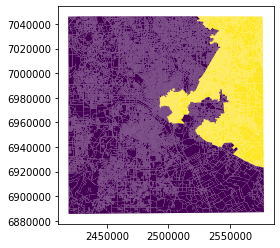

In [232]:
Partition(h.graph, {n: districts[23][h.graph.nodes[n]["geoid"]] for n in h.graph.nodes}).plot()

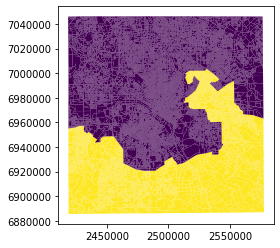

In [266]:
Partition(h.graph, {n: districts[202][h.graph.nodes[n]["geoid"]] for n in h.graph.nodes}).plot()

In [14]:
results = pd.read_csv("data/dallas_district_vars_empirical.csv")

In [135]:
# results = pd.DataFrame(vs, columns=["variance"]).assign(split="equal", multi_attr=True, eps=1)

In [274]:
results.to_csv("data/dallas_district_vars_empirical.csv", index=False)

In [28]:
test = pd.DataFrame(analytical_tree.query("eps == 1")).rename(columns={"var": "variance", 
                              "type": "split"}).replace({"split": {"eq": "equal", 
                                                                   "tp": "top_heavy", 
                                                                   "md": "mid_heavy",
                                                                   "bt": "bottom_heavy"}}).assign(multi_attr=False)
#["var"].values, 
                    #columns=["variance"]).assign(split="equal", multi_attr=False)

In [275]:
both.to_csv("data/dallas_district_vars_empirical_analytical.csv", index=False)

In [16]:
both = results.append(test)

In [199]:
results.query("split == 'equal'")["variance"].values.shape

(203,)

In [200]:
# results.query("split == 'equal'")["variance"].values# == 
results.query("split == 'bottom_heavy'")["variance"].values.shape

(203,)

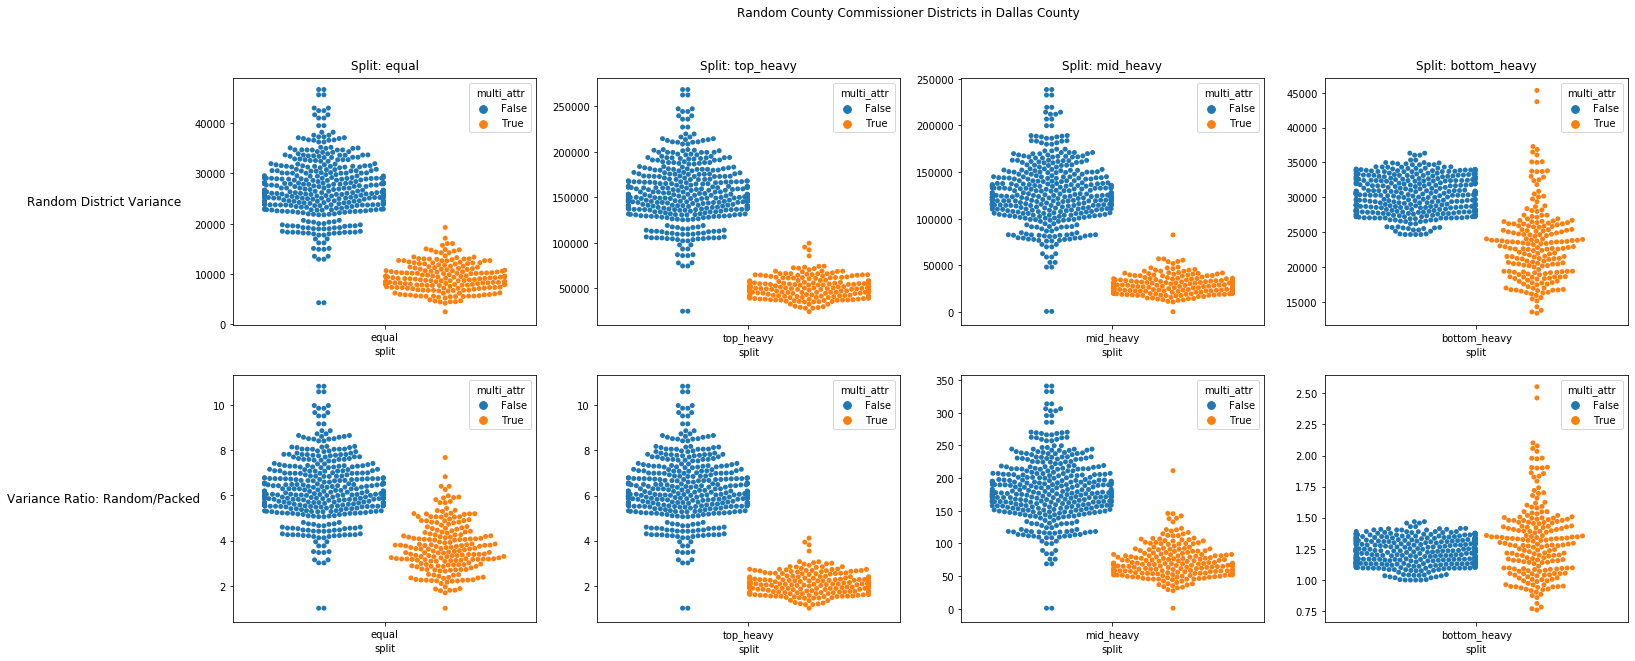

In [17]:
fig, axs = plt.subplots(2,4, figsize=(25,10))

fig.suptitle("Random County Commissioner Districts in Dallas County")

for i,t in enumerate(["equal", "top_heavy", "mid_heavy", "bottom_heavy"]):
#     axs[0,i].set_title(t)
    sns.swarmplot(data=both.query("split == @t"), y="variance", x="split", hue="multi_attr",
                  dodge=True, ax=axs[0,i])
    sns.swarmplot(data=both.query("split == @t"), y="ratio", x="split", hue="multi_attr",
                  dodge=True, ax=axs[1,i])
    axs[0,i].set_ylabel('')
    axs[1,i].set_ylabel('')
#     sns.swarmplot(data=data.query("type==@t & eps==1"), y="var", ax=axs[1, i])

pad = 5
for ax, col in zip(axs[0], ["Split: {}".format(s) for s in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
    
for ax, row in zip(axs[:,0], ["Random District Variance", "Variance Ratio: Random/Packed"]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
    
# plt.savefig("plots/dallas_county_districts_by_split.png", dpi=200)
plt.show()

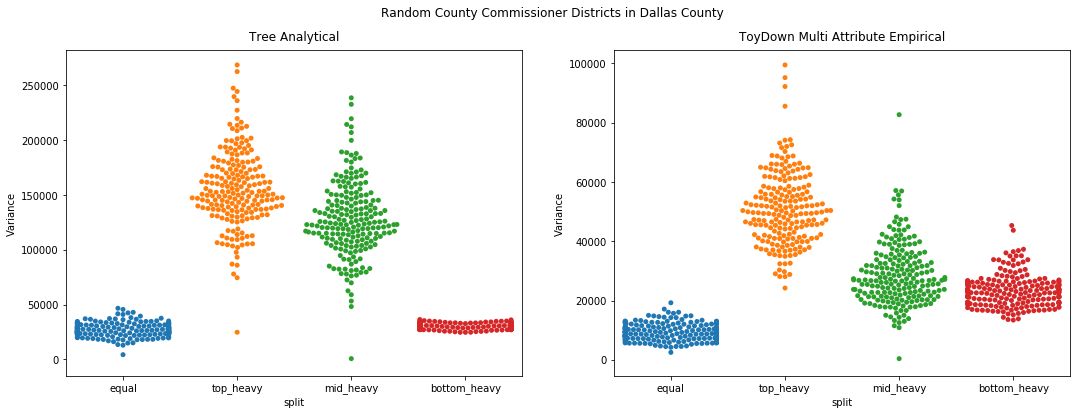

In [30]:
fig, axs = plt.subplots(1,2, figsize=(18,6))

fig.suptitle("Random County Commissioner Districts in Dallas County")

for i, data in enumerate([test, results]):
    sns.swarmplot(data=data, y="variance", x="split", dodge=True, ax=axs[i])
#     sns.swarmplot(data=data, y="ratio", x="split", dodge=True, ax=axs[1,i])
    axs[i].set_ylabel('Variance')
#     axs[1,i].set_ylabel('')

pad = 5
for ax, col in zip(axs, ["Tree Analytical","ToyDown Multi Attribute Empirical"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
    
# for ax, row in zip(axs[:,0], ["Random District Variance", "Variance Ratio: Random/Packed"]):
#         ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                     xycoords=ax.yaxis.label, textcoords='offset points',
#                     size='large', ha='right', va='center')
        
plt.savefig("plots/dallas_county_districts_by_model_no_ratio.png", dpi=200, bbox_inches="tight")
plt.show()

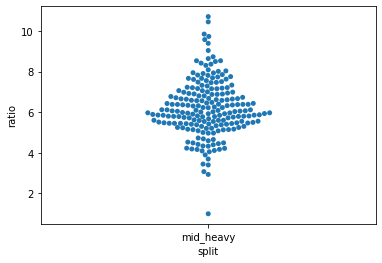

In [241]:
sns.swarmplot(data=both.query("split == 'mid_heavy' & multi_attr == False"), y="ratio", x="split",
                  dodge=True)

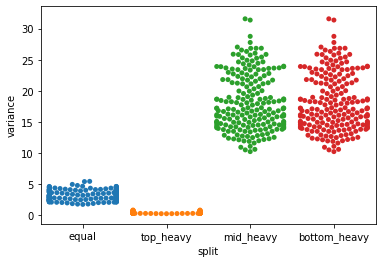

In [26]:
sns.swarmplot(data=test, y="variance", x="split", dodge=True)

In [29]:
test.query("split== 'equal'")

,ratio,variance,split,eps,multi_attr
0,5.214110,22418.725283,equal,1,False
1,5.588419,24028.114711,equal,1,False
2,8.582101,36899.828664,equal,1,False
3,5.927300,25485.177802,equal,1,False
4,6.779161,29147.860756,equal,1,False
...,...,...,...,...,...
198,7.877978,33872.364123,equal,1,False
199,6.145752,26424.437191,equal,1,False
200,7.943699,34154.939923,equal,1,False
201,6.053388,26027.306848,equal,1,False


In [15]:
def district_frag_scores(h, districts):
    num_districts = len(districts)
    frag_scores = np.zeros(num_districts)
    for i in tqdm(range(num_districts)):
        frag_scores[i] = h.assign_district_tree_variance(districts[i],eps=1, eps_splits=[np.sqrt(2)]*5)
    return frag_scores

In [16]:
frag_scores = district_frag_scores(h,districts)

100%|██████████| 203/203 [01:21<00:00,  2.48it/s]


In [31]:
data = pd.read_csv("data/dallas_district_vars_empirical_analytical.csv")#.query("split == 'equal'")

In [36]:
data

,variance,split,multi_attr,eps,ratio,frag_score
0,7549.311157,equal,True,1.0,3.013454,448.374506
1,6188.165955,equal,True,1.0,2.470126,480.562294
2,9873.158936,equal,True,1.0,3.941063,737.996573
3,5610.701172,equal,True,1.0,2.239620,509.703556
4,9087.427124,equal,True,1.0,3.627423,582.957215
...,...,...,...,...,...,...
1619,48443.645869,bottom_heavy,False,1.0,1.957015,677.447282
1620,42236.240293,bottom_heavy,False,1.0,1.706250,528.488744
1621,47316.266329,bottom_heavy,False,1.0,1.911471,683.098798
1622,41720.839181,bottom_heavy,False,1.0,1.685429,520.546137


In [35]:
data["frag_score"] = np.append(frag_scores,[frag_scores]*7)

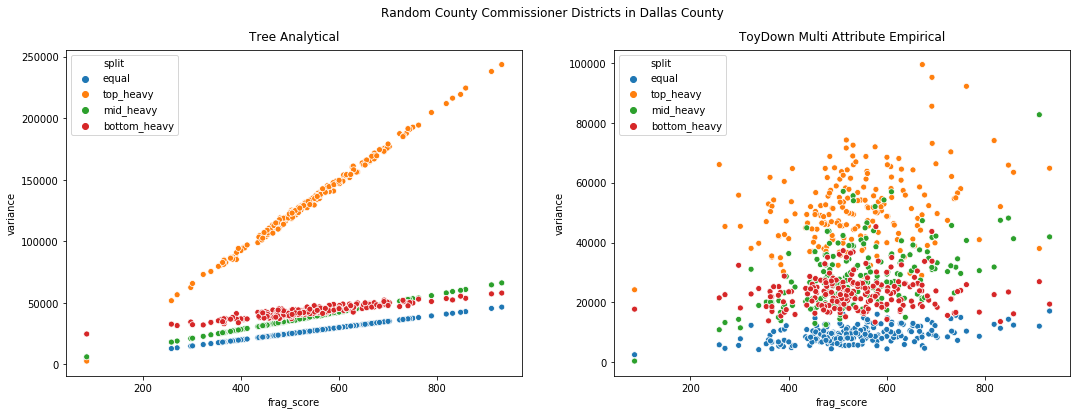

In [48]:
fig, axs = plt.subplots(1,2, figsize=(18,6))

fig.suptitle("Random County Commissioner Districts in Dallas County")
sns.scatterplot(data=data.query("not multi_attr"), x="frag_score", y="variance", hue="split", ax=axs[0])
sns.scatterplot(data=data.query("multi_attr"), x="frag_score", y="variance", hue="split", ax=axs[1])

pad = 5
for ax, col in zip(axs, ["Tree Analytical","ToyDown Multi Attribute Empirical"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
plt.savefig("plots/dallas_county_districts_by_model_frag_vs_var.png", dpi=200, bbox_inches="tight")
plt.show()